<a href="https://colab.research.google.com/github/akshatsingh22/Detailed-Architechture-of-different-CNNs/blob/master/VGG_16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**UNZIP THE DATASET IN ./CONTENT NOT IN DRIVE FOR FASTER PROCESSING**

In [0]:
# !unzip '/content/drive/My Drive/COMPUTER VISION DOCS/imagenette_6class.zip'

**DEFINE TEST, TRAIN AND VALIDATION DATASET DIRECTORY**

In [0]:
import os
base_dir='/content'

train_data = os.path.join(base_dir, 'train')
validate_data = os.path.join(base_dir, 'validation')
test_data = os.path.join(base_dir, 'test')

**IMPORT NECESSARY LAYERS, LOSSES AND METRICES**

In [3]:
# import all the necessary layers & arguments 
import tensorflow as tf
print(tf.__version__)

from tensorflow_addons import metrics as tfa_metrics
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.python.keras.layers import Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

from sklearn import metrics
from sklearn.metrics import confusion_matrix

from tensorflow.python.keras import optimizers
import numpy as np
import matplotlib.pyplot as plt

2.2.0


**LOAD THE DATASET USING IMAGE DATA GENERATOR APPLY DATA AUGMENTATION**

In [4]:
#  Using ImageDataGenerator to read images from directories 
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

print(train_data)
print(validate_data)

batch_size=32  #Using a batch size of 32
train_generator = train_datagen.flow_from_directory(
    train_data, 
    target_size=(224, 224), 
    batch_size=batch_size,
    class_mode='categorical') # Using 'categorical' as class mode as we have only two classes.

validation_generator = validation_datagen.flow_from_directory(
    validate_data,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical')

/content/train
/content/validation
Found 7200 images belonging to 6 classes.
Found 600 images belonging to 6 classes.


**BUILD THE STANDARD VGG-16 NETWORK**

In [5]:
#Build the standard VGG16 network
model = Sequential()
model.add(Conv2D(input_shape=(224,224,3),filters=32,kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same'))
model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same',))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same',))
model.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same',))
model.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same',))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same',))
model.add(Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same',))
model.add(Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same',))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same',))
model.add(Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same',))
model.add(Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same',))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Flatten())
model.add(Dense(units=4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=6, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 56, 56, 256)       2

**DISPLAY BATCH AND LABELS**

In [6]:
# Displaying the shapes of a batch of data and labels
for data_batch, labels_batch in train_generator:
    print('data batch:', data_batch.shape)
    print('labels batch:', labels_batch.shape)
    break

data batch: (32, 224, 224, 3)
labels batch: (32, 6)


**DEFINE THE TIME CALLBACK TO CALCULATE THE TOTAL COMPUTATION TIME**

In [0]:
from time import time
class TimingCallback(tf.keras.callbacks.Callback):
    def __init__(self, logs={}):
        self.logs=[]
        self.total_time = 0
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = time()
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(time()-self.starttime)
    def on_train_end(self, logs=None):
        self.total_time = sum(self.logs)

cb = TimingCallback()

**SETTING UP ALL THE METRICES AND COMPILED THE MODEL**

In [0]:
#setting metrics
precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()
accuracy = tf.keras.metrics.CategoricalAccuracy() 
f1_score = tfa_metrics.F1Score(6)

model.compile(loss='categorical_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), 
              metrics=[accuracy, recall, precision, f1_score])

**DEFINE EPOCHS AND STARTED TRAINING**

In [9]:
number_of_epochs=50  #Setting the number of epochs
history = model.fit(
   train_generator,
   steps_per_epoch=train_generator.n//batch_size, #Setting steps per epoch using general rule of thumb
   epochs=number_of_epochs, 
   validation_data=validation_generator,
   validation_steps=validation_generator.n//batch_size, #Setting steps per epoch using general rule of thumb
   callbacks=[cb])

Epoch 1/50
225/225 [==============================] - 135s 600ms/step - loss: 1.7908 - categorical_accuracy: 0.1700 - recall: 0.6081 - precision: 0.1673 - f1_score: 0.1473 - val_loss: 1.7917 - val_categorical_accuracy: 0.1701 - val_recall: 0.5069 - val_precision: 0.1690 - val_f1_score: 0.0485
Epoch 2/50
225/225 [==============================] - 136s 603ms/step - loss: 1.7929 - categorical_accuracy: 0.1597 - recall: 0.6085 - precision: 0.1666 - f1_score: 0.1406 - val_loss: 1.7917 - val_categorical_accuracy: 0.1736 - val_recall: 0.5017 - val_precision: 0.1672 - val_f1_score: 0.0493
Epoch 3/50
225/225 [==============================] - 135s 600ms/step - loss: 1.7920 - categorical_accuracy: 0.1661 - recall: 0.7376 - precision: 0.1661 - f1_score: 0.1401 - val_loss: 1.7915 - val_categorical_accuracy: 0.1667 - val_recall: 0.6667 - val_precision: 0.1667 - val_f1_score: 0.0476
Epoch 4/50
225/225 [==============================] - 136s 606ms/step - loss: 1.6704 - categorical_accuracy: 0.2612 - 

**EVALUATE THE NETWORK ON PREVIOUSLY UNSEEN TEST DATASET**

In [10]:
# Evaluating the model - test on finalised model

#Load the test data
test_generator = test_datagen.flow_from_directory(
    test_data,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

print('Evaluating the network ...')
# Evaluating the network
results = model.evaluate(test_generator, steps=test_generator.n//batch_size)
print(results)
#Saving our model
model.save('VGG_Part_E.h5')

Found 300 images belonging to 6 classes.
Evaluating the network ...
9/9 [==============================] - 2s 167ms/step - loss: 0.1961 - categorical_accuracy: 0.9444 - recall: 0.9340 - precision: 0.9539 - f1_score: 0.9445
[0.19608044624328613, 0.9444444179534912, 0.9340277910232544, 0.9539006948471069, array([0.989899 , 0.9183674, 0.9387755, 0.92     , 0.9514563, 0.9487179],
      dtype=float32)]


**PRINT FINAL TEST LOSS AND TEST ACCURACY**

In [11]:
print('Final loss is:', (results[0]))
print('Final test accuracy:', (results[1]*100.0))

Final loss is: 0.19608044624328613
Final test accuracy: 94.44444179534912


**CALCULATE CO2 EMISSION IN KG USING A FACTOR 0.28307 KG CO2/1 KWh ELECTRICITY**

In [12]:
NVIDIA_80K_TDP = 300 / 1000 #kW
TRAINING_TIME = cb.total_time
CONSUMED_ENERGY = NVIDIA_80K_TDP * TRAINING_TIME/3600 #kWh
CO2_emission = CONSUMED_ENERGY * 0.28307 #kg
CO2_emission

0.16094574010038354

**PRINT CLASS INDICES TO USE FOR CONFUSSION MATRIX**

In [0]:
test_generator.class_indices
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

**PLOT CONFUSION MATRIX**

10/10 [==============================] - 2s 248ms/step
Confusion matrix, without normalization
[[49  0  0  0  1  0]
 [ 0 45  1  1  1  2]
 [ 0  0 46  1  2  1]
 [ 0  3  1 46  0  0]
 [ 0  0  0  1 49  0]
 [ 0  0  0  1  0 49]]


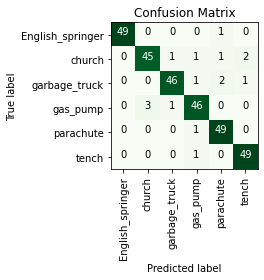

In [14]:
test_labels = test_generator.classes
predictions = model.predict(test_generator, steps=np.ceil(test_generator.n / batch_size), verbose=1)
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))
cm_plot_labels = test_generator.class_indices.keys()
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix') 

**TAKING OUT INDICES AND LABELS TO CALCULATE THE CLASSIFICATION REPORT**

In [15]:
# Get the index of the class with the highest probability score
y_pred = np.argmax(predictions, axis=1)
# Get the labels of the test images.
y_true = test_generator.classes
from sklearn.metrics import classification_report

# Generate a classification report
report = classification_report(y_true, y_pred, target_names=cm_plot_labels)

print(report)
from sklearn.metrics import precision_score , recall_score,f1_score

m1 = precision_score(y_true ,y_pred, average='micro') #test part of label
m2 = recall_score(y_true ,y_pred, average='micro')
m3 = f1_score(y_true ,y_pred, average='micro')
print(m1, m2, m3)

                  precision    recall  f1-score   support

English_springer       1.00      0.98      0.99        50
          church       0.94      0.90      0.92        50
   garbage_truck       0.96      0.92      0.94        50
        gas_pump       0.92      0.92      0.92        50
       parachute       0.92      0.98      0.95        50
           tench       0.94      0.98      0.96        50

        accuracy                           0.95       300
       macro avg       0.95      0.95      0.95       300
    weighted avg       0.95      0.95      0.95       300

0.9466666666666667 0.9466666666666667 0.9466666666666667


**PLOT TRAINING LOSS, TRAINING ACCURACY, PRECISION, RECALL, F1SCORE DIAGRAMS**

In [0]:
def plot_metrics(history):

    import matplotlib as mpl
    mpl.rcParams['figure.figsize'] = (16, 16)
    metrics =  model.metrics_names
    metrics = ['loss', 'categorical_accuracy', 'recall', 'precision', 'f1_score']
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(3,2,n+1)
        if isinstance(history,list):
            epochs = list(range(len(history) * len(history[0].epoch)))
            train_metrics = sum([[value for value in hist.history[metric]] for hist in history],[])
            val_metrics = sum([[value for value in hist.history['val_'+metric]] for hist in history],[])
            plt.plot(epochs,  train_metrics, color=colors[0], label='Train')
            plt.plot(epochs, val_metrics,
                 color=colors[1], label='Val')
        else:
            plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
            plt.plot(history.epoch, history.history['val_'+metric],
                     color=colors[1], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        else:
            plt.ylim([0,1])

        plt.legend()

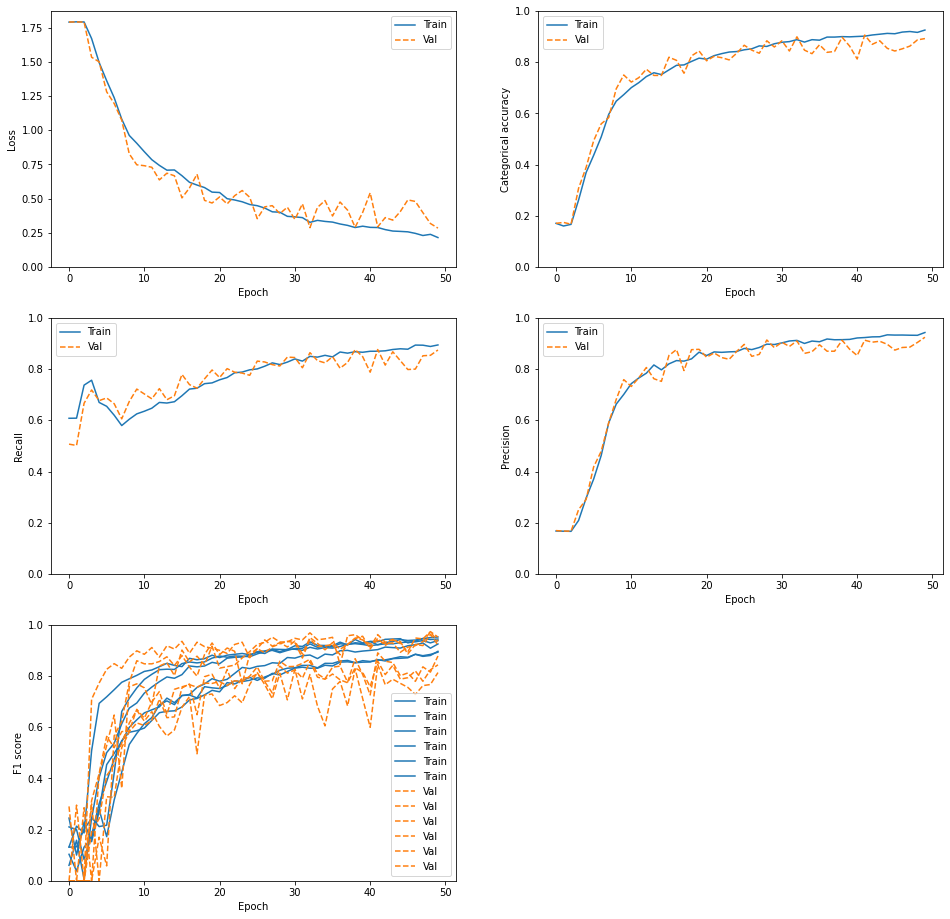

In [17]:
plot_metrics(history)